Enter run number (e.g., 0002):  0000



Trovati 4 file corrispondenti al run 0000:
  [0] WC_proto_0000_1Gs_20PT.h5.gz
  [1] WC_proto_0000_1Gs_50PT.h5.gz
  [2] WC_proto_0000_1Gs_90PT.h5.gz
  [3] WC_proto_0000_2.5Gs_90PT.h5.gz



Seleziona il file da aprire (indice):  0


→ Decompressione in corso...

📄 HEADER /config:
  → RunNumber         = 0
  → RecordLength      = 1024
  → PostTriggerSize   = 20%
  → SamplingTime      = 1.0 ns
  → TriggerMode       = External
  → ChannelList       = [0, 1, 2, 3, 4, 5, 6, 7]

→ Numero eventi nel file: 10



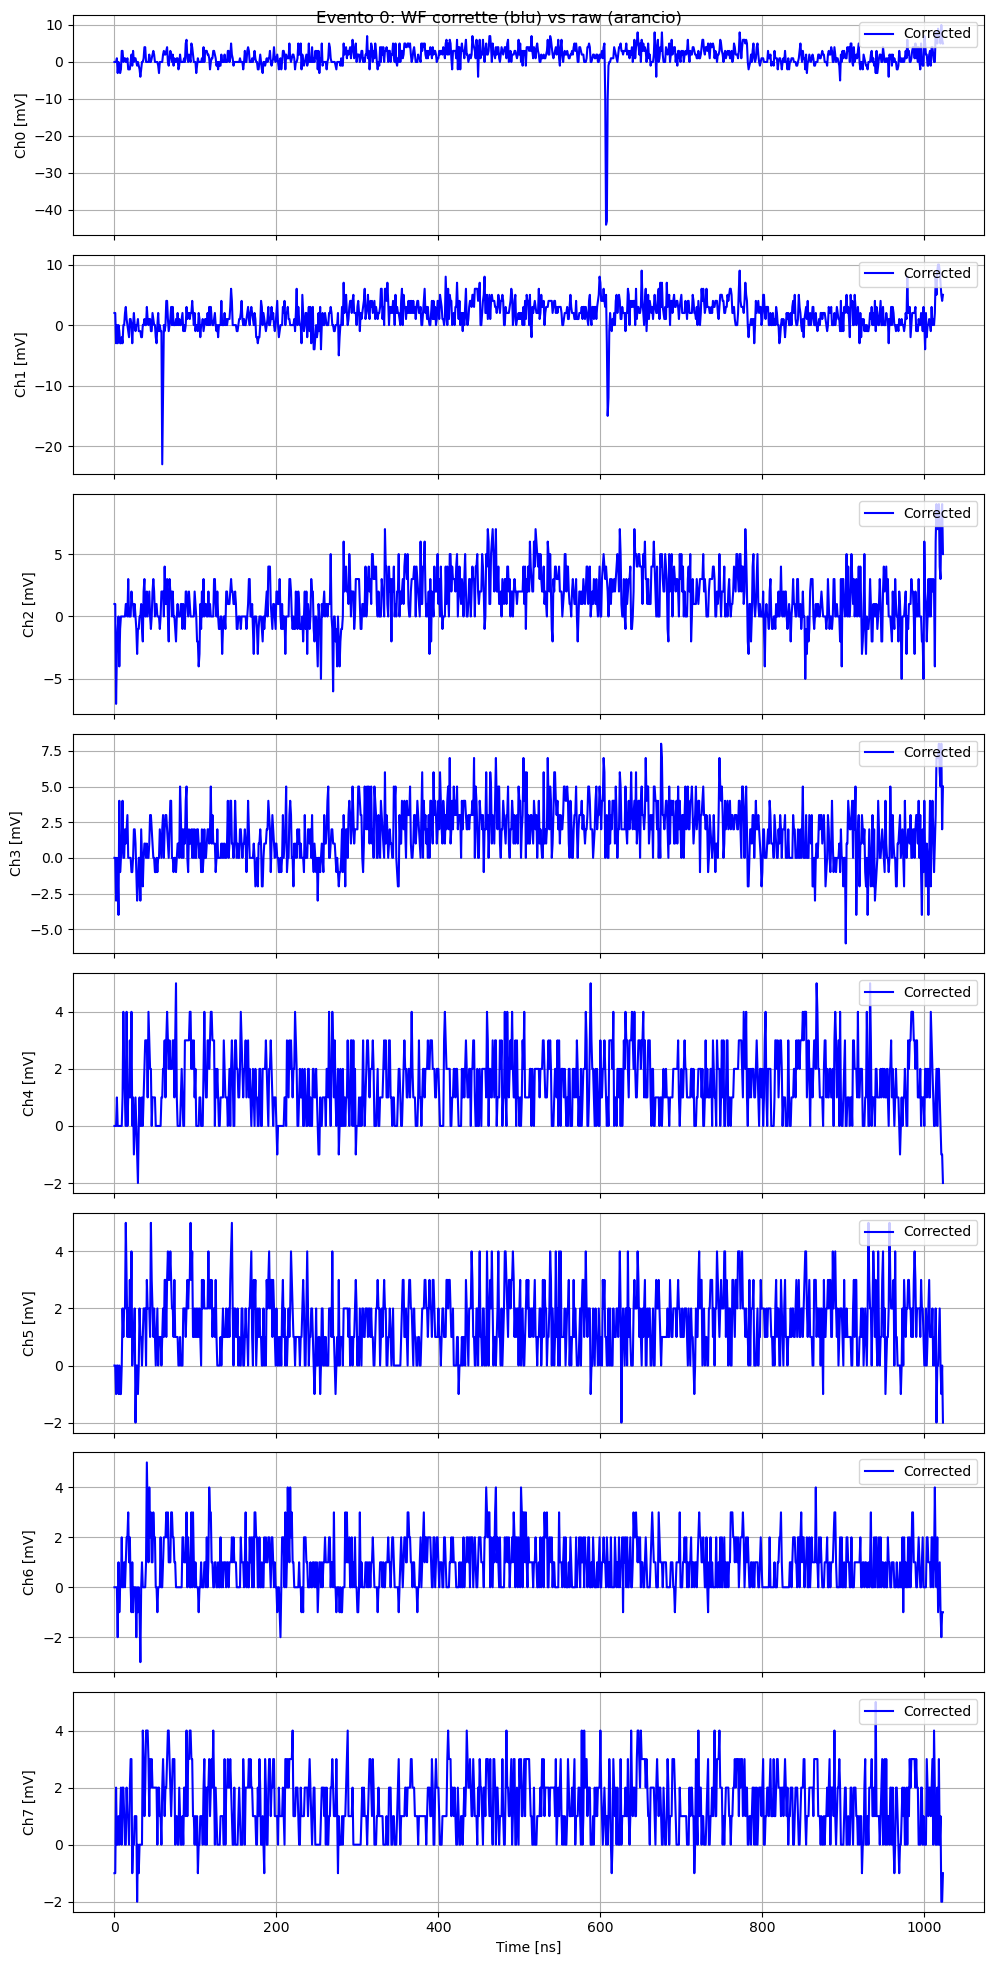

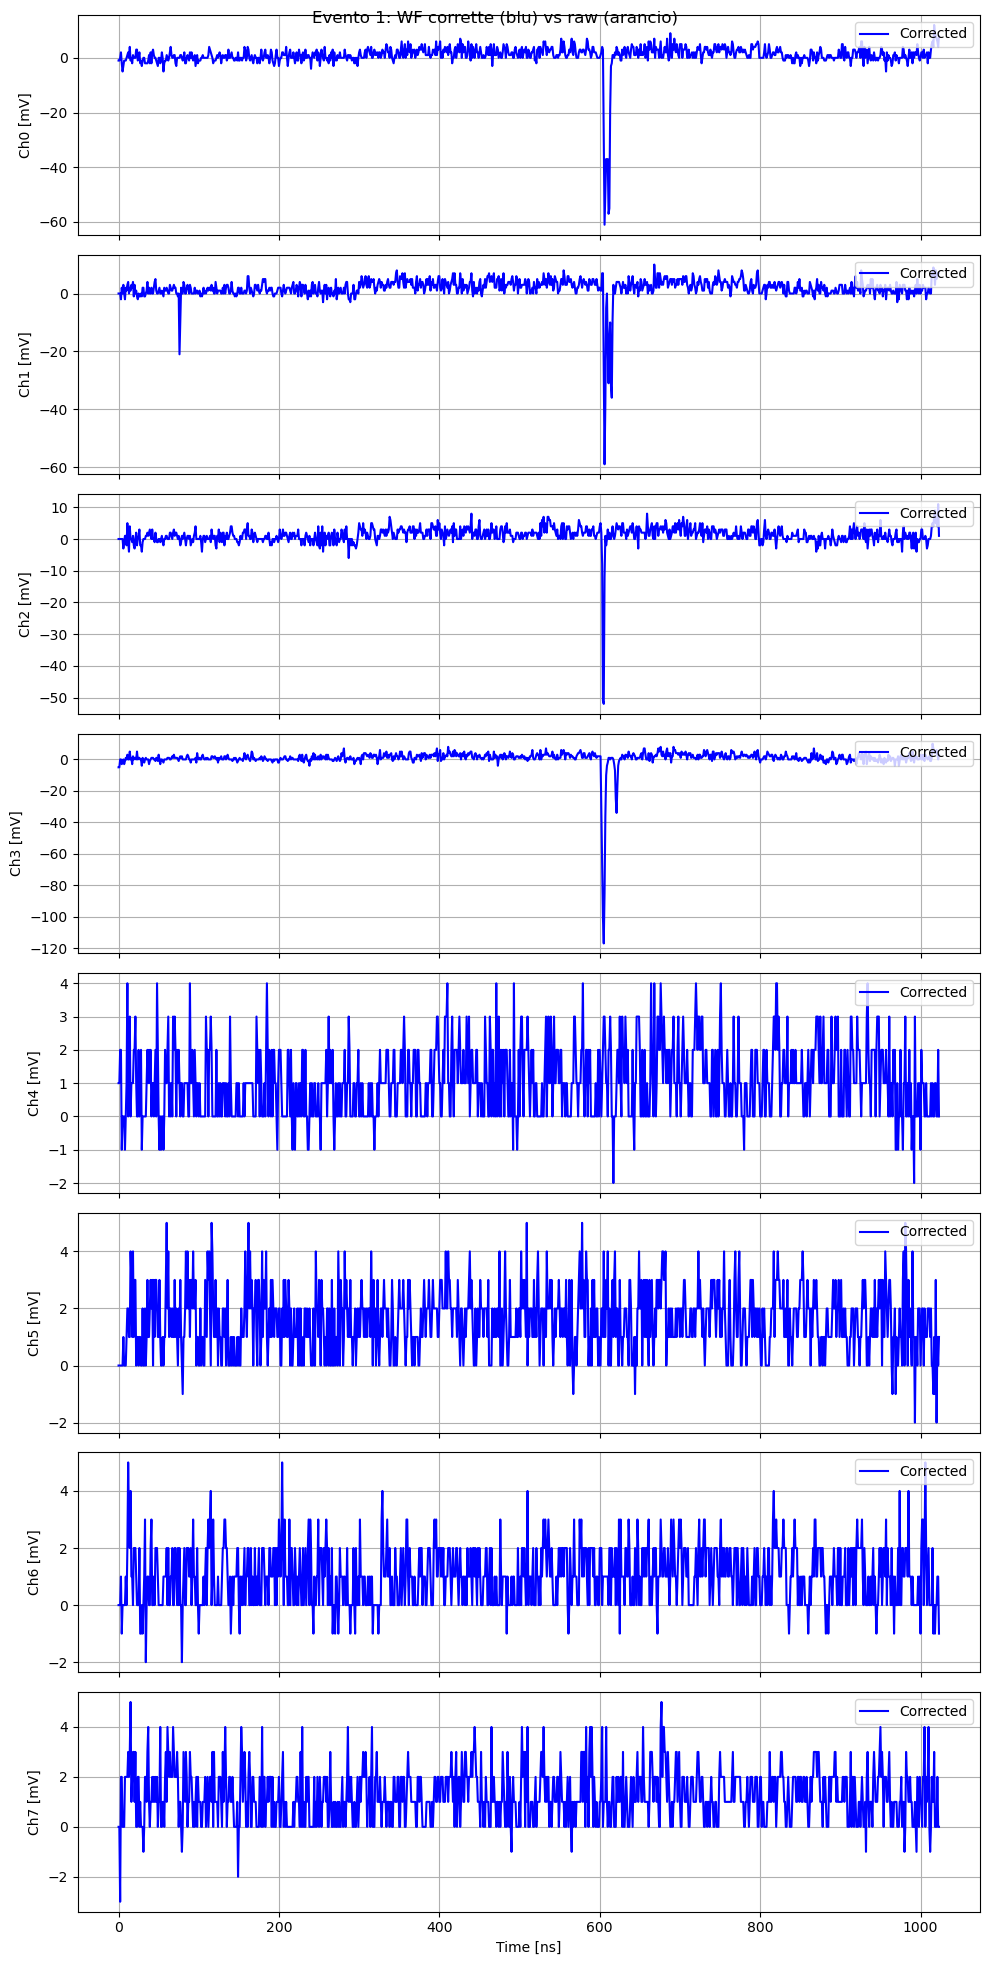

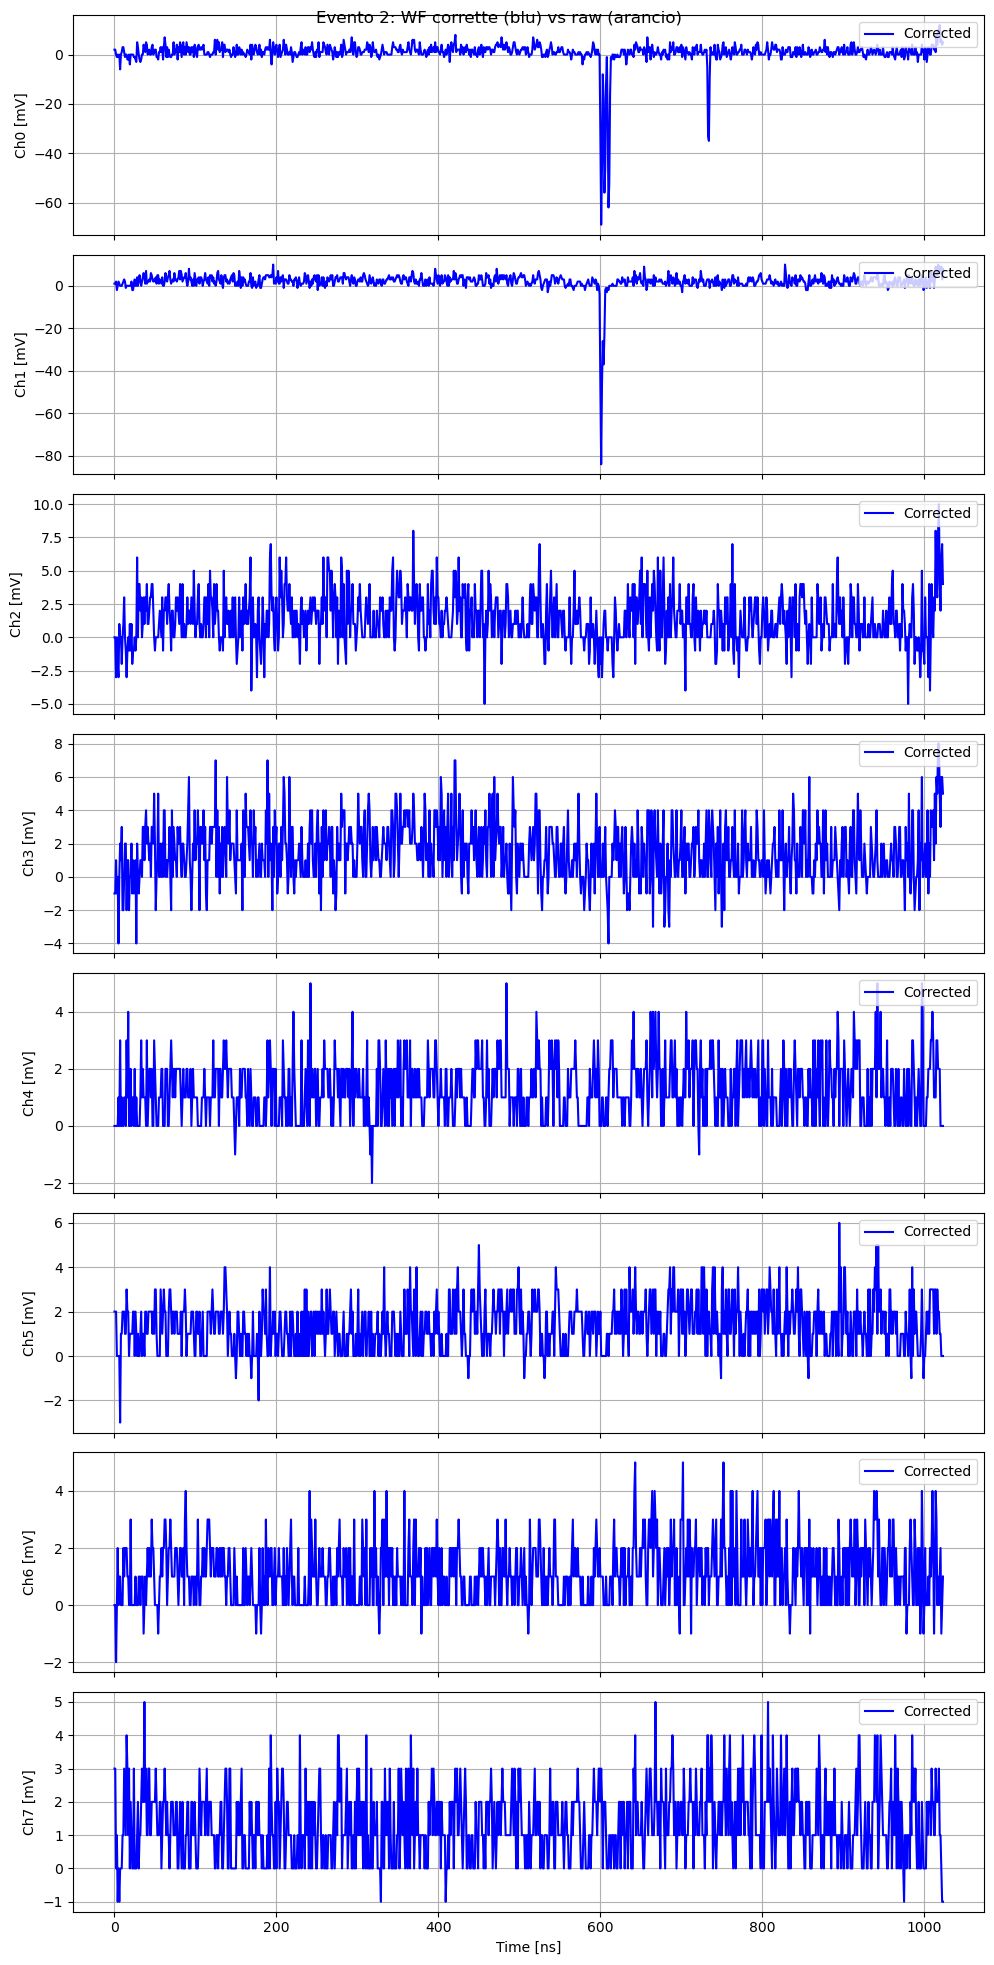

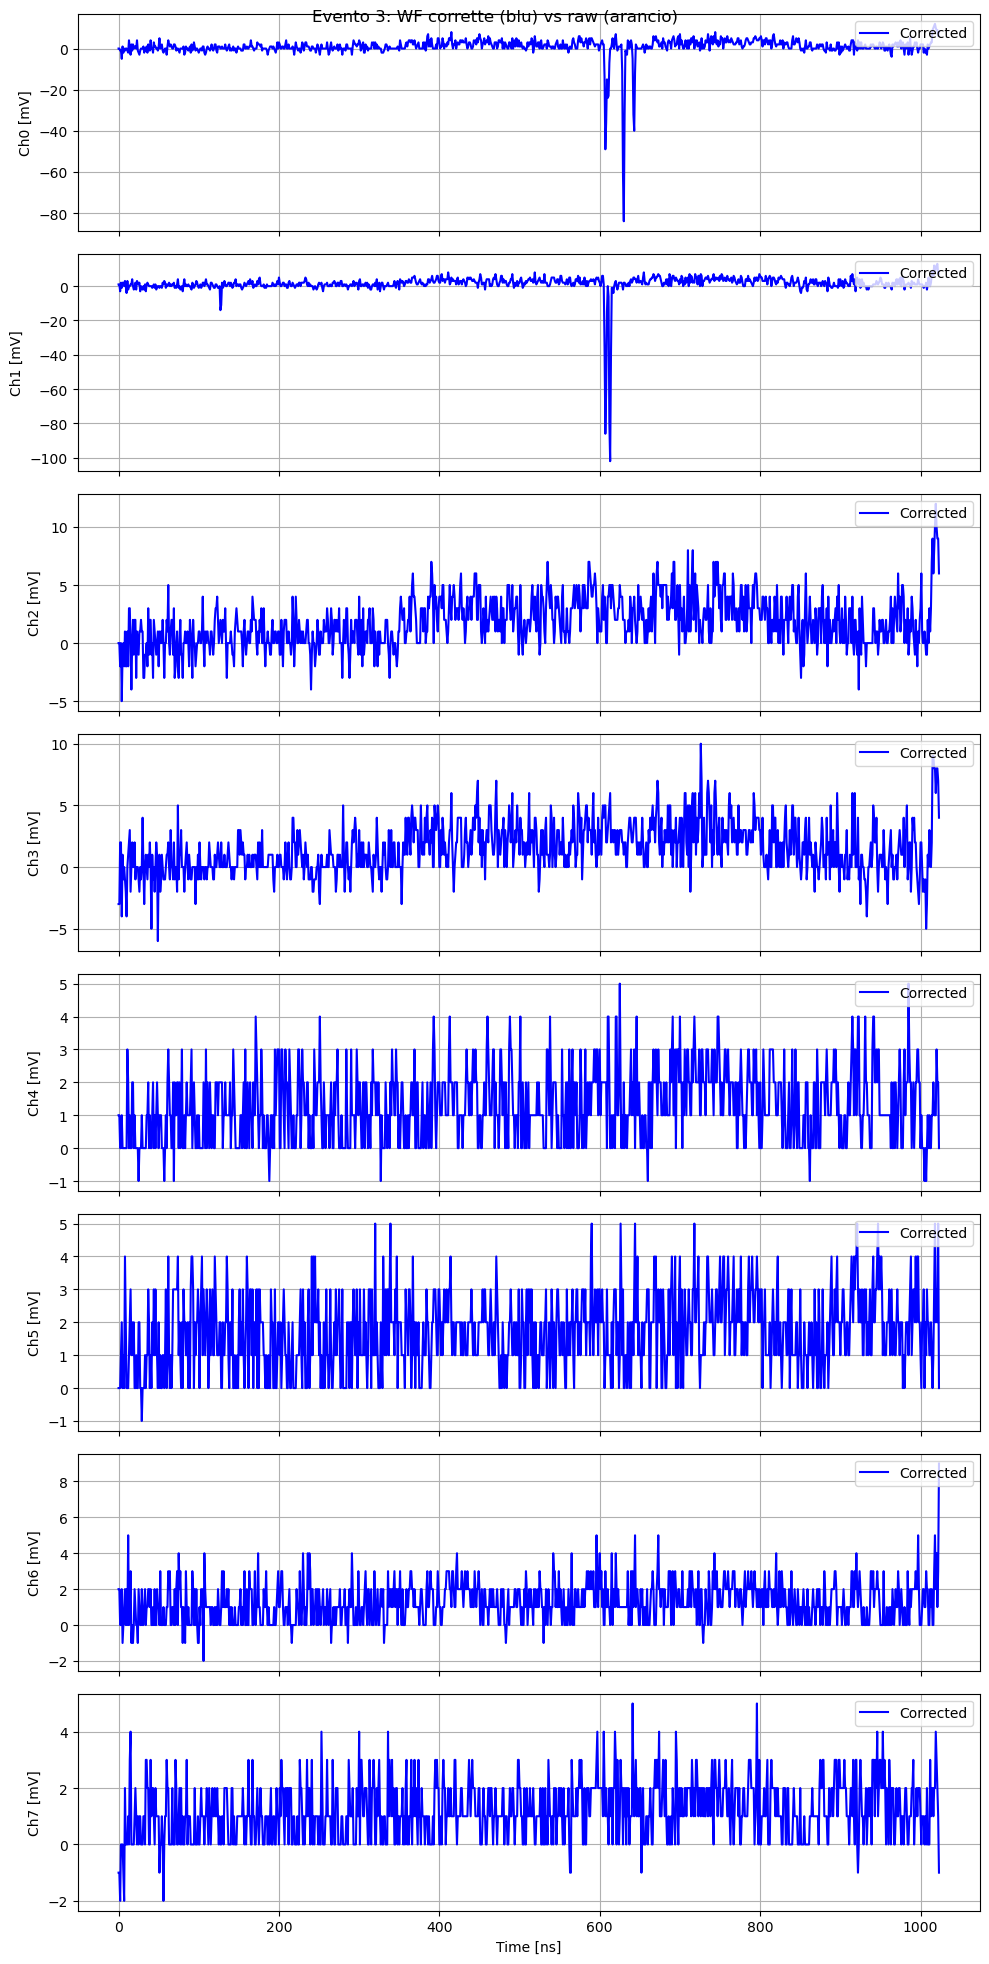

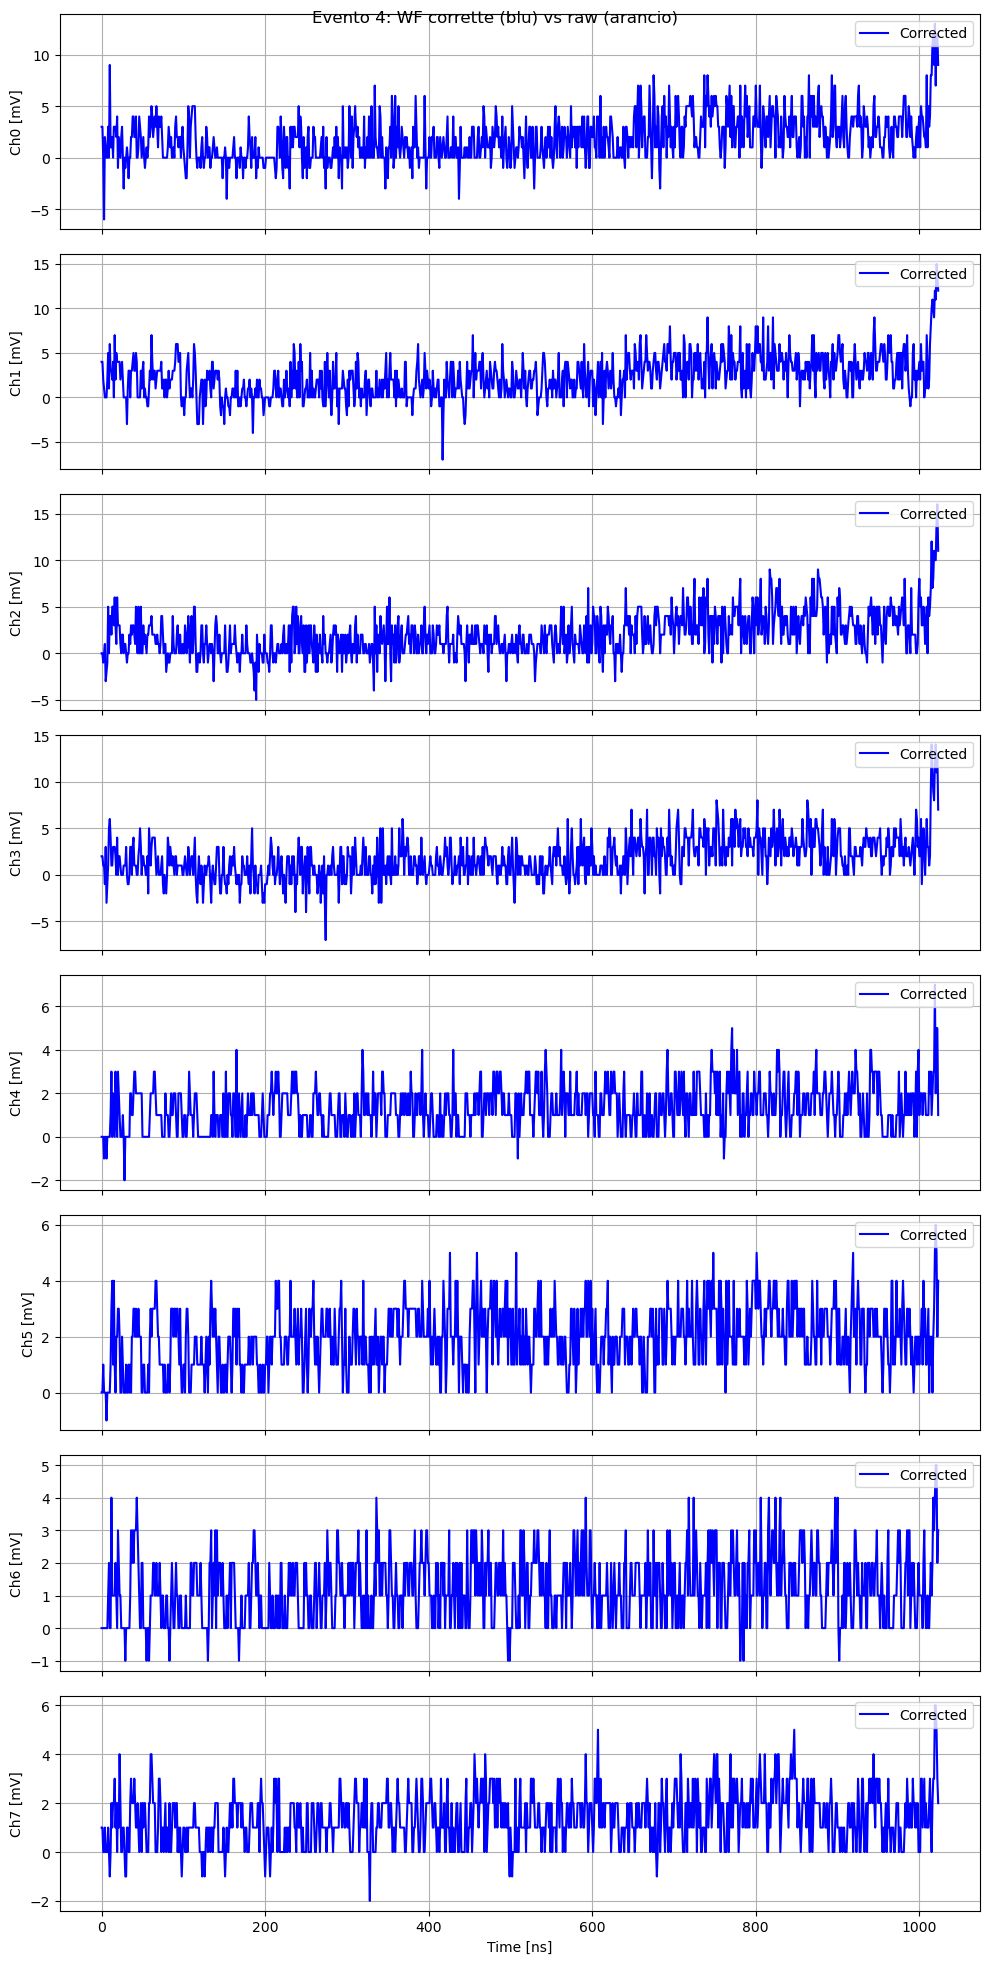

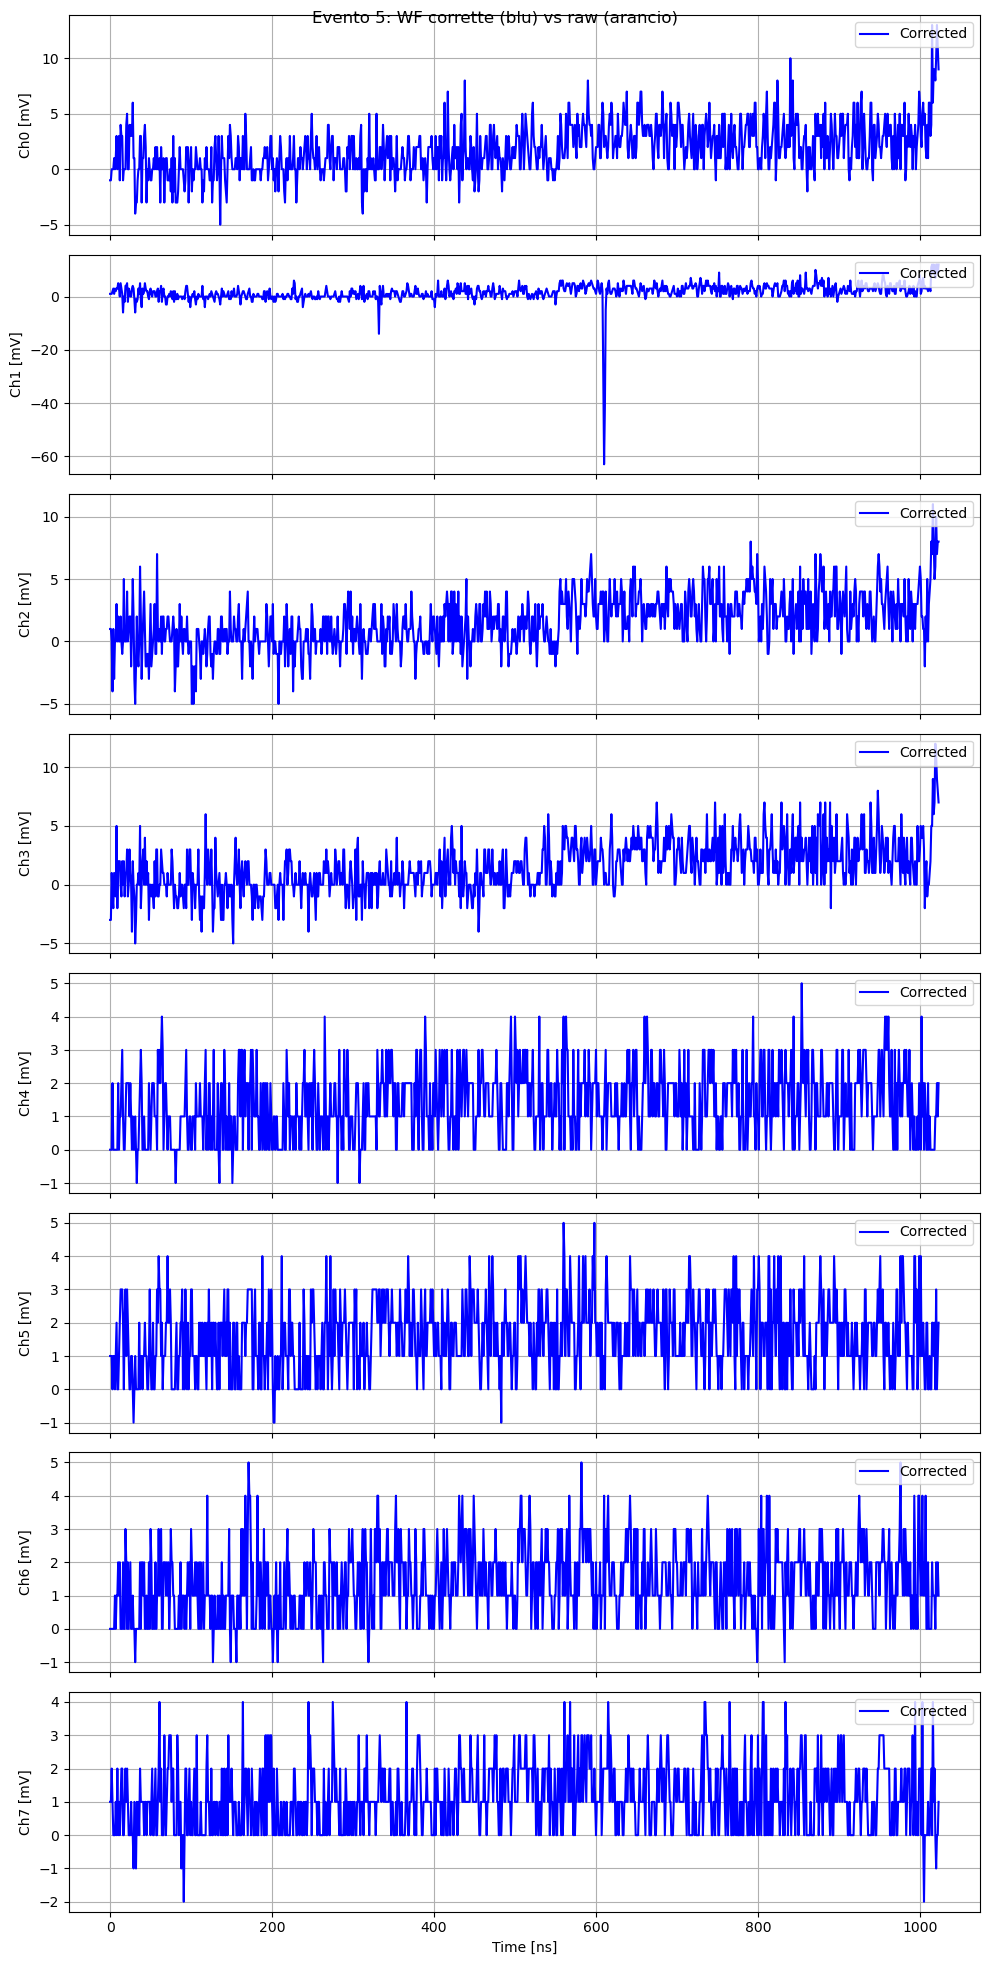

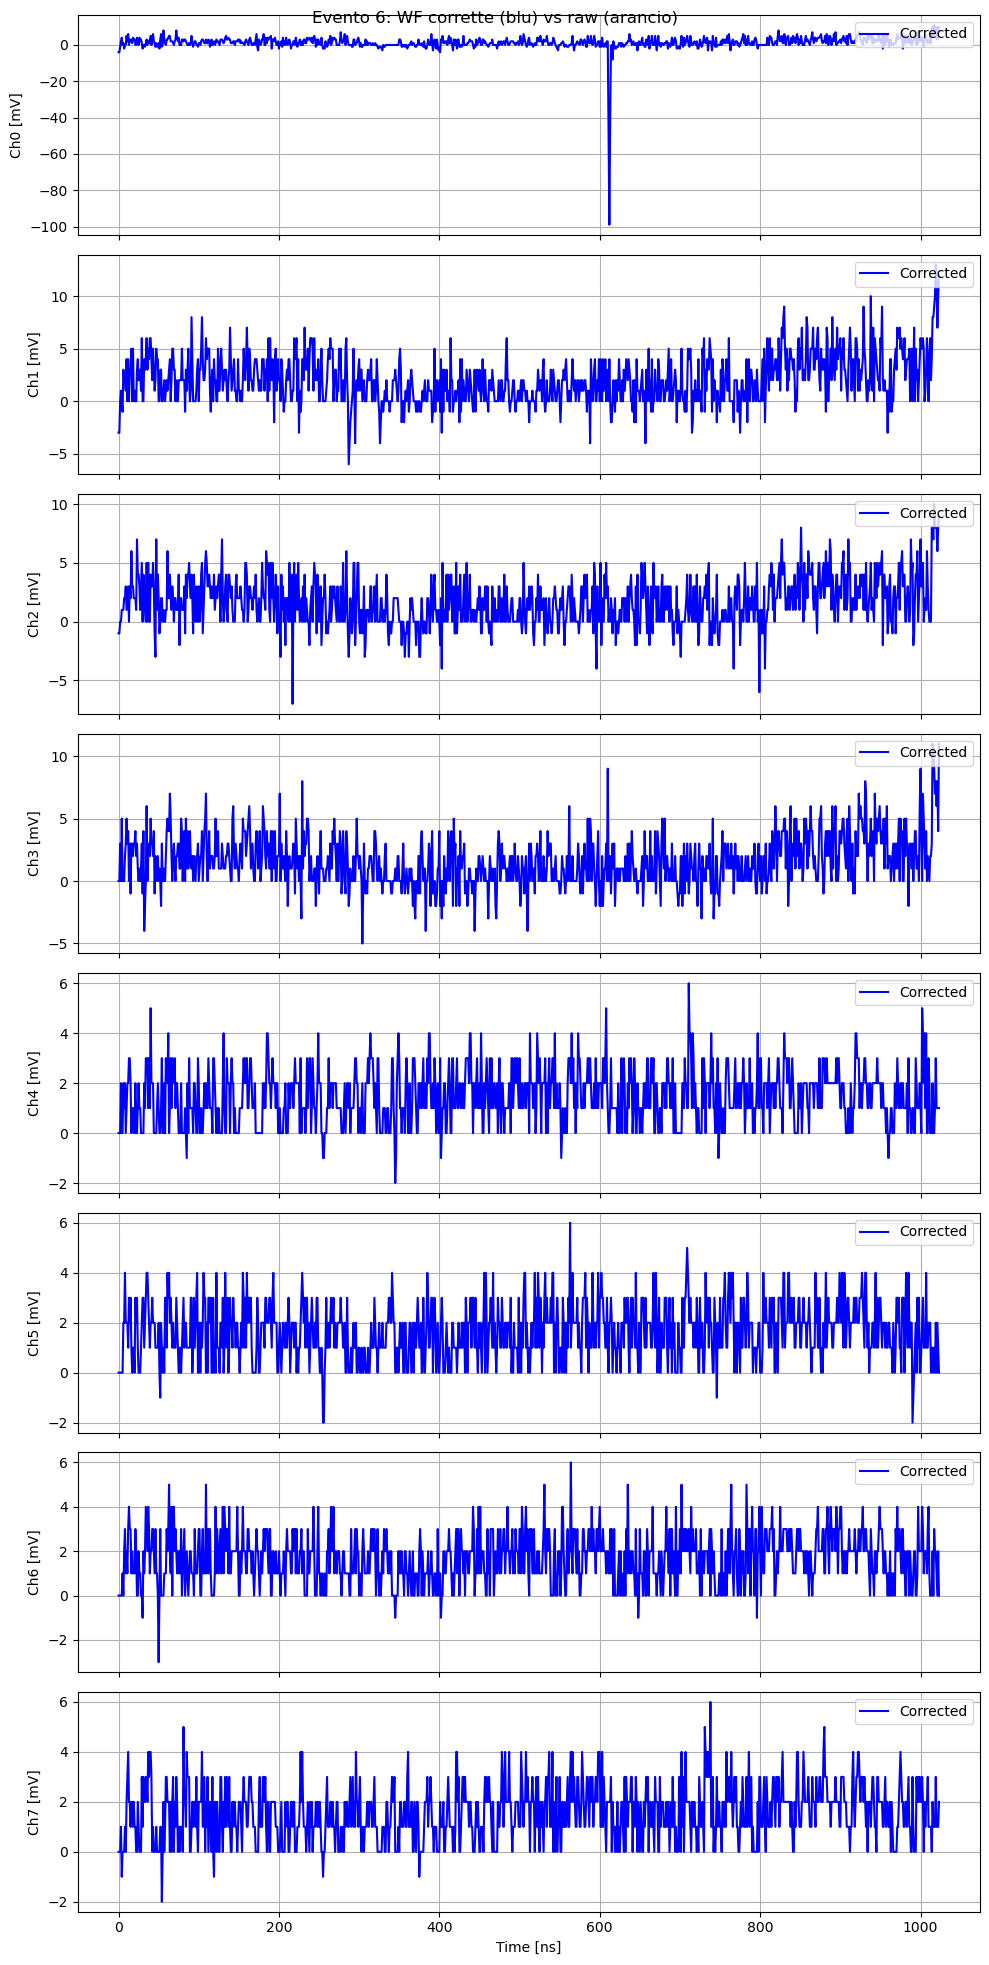

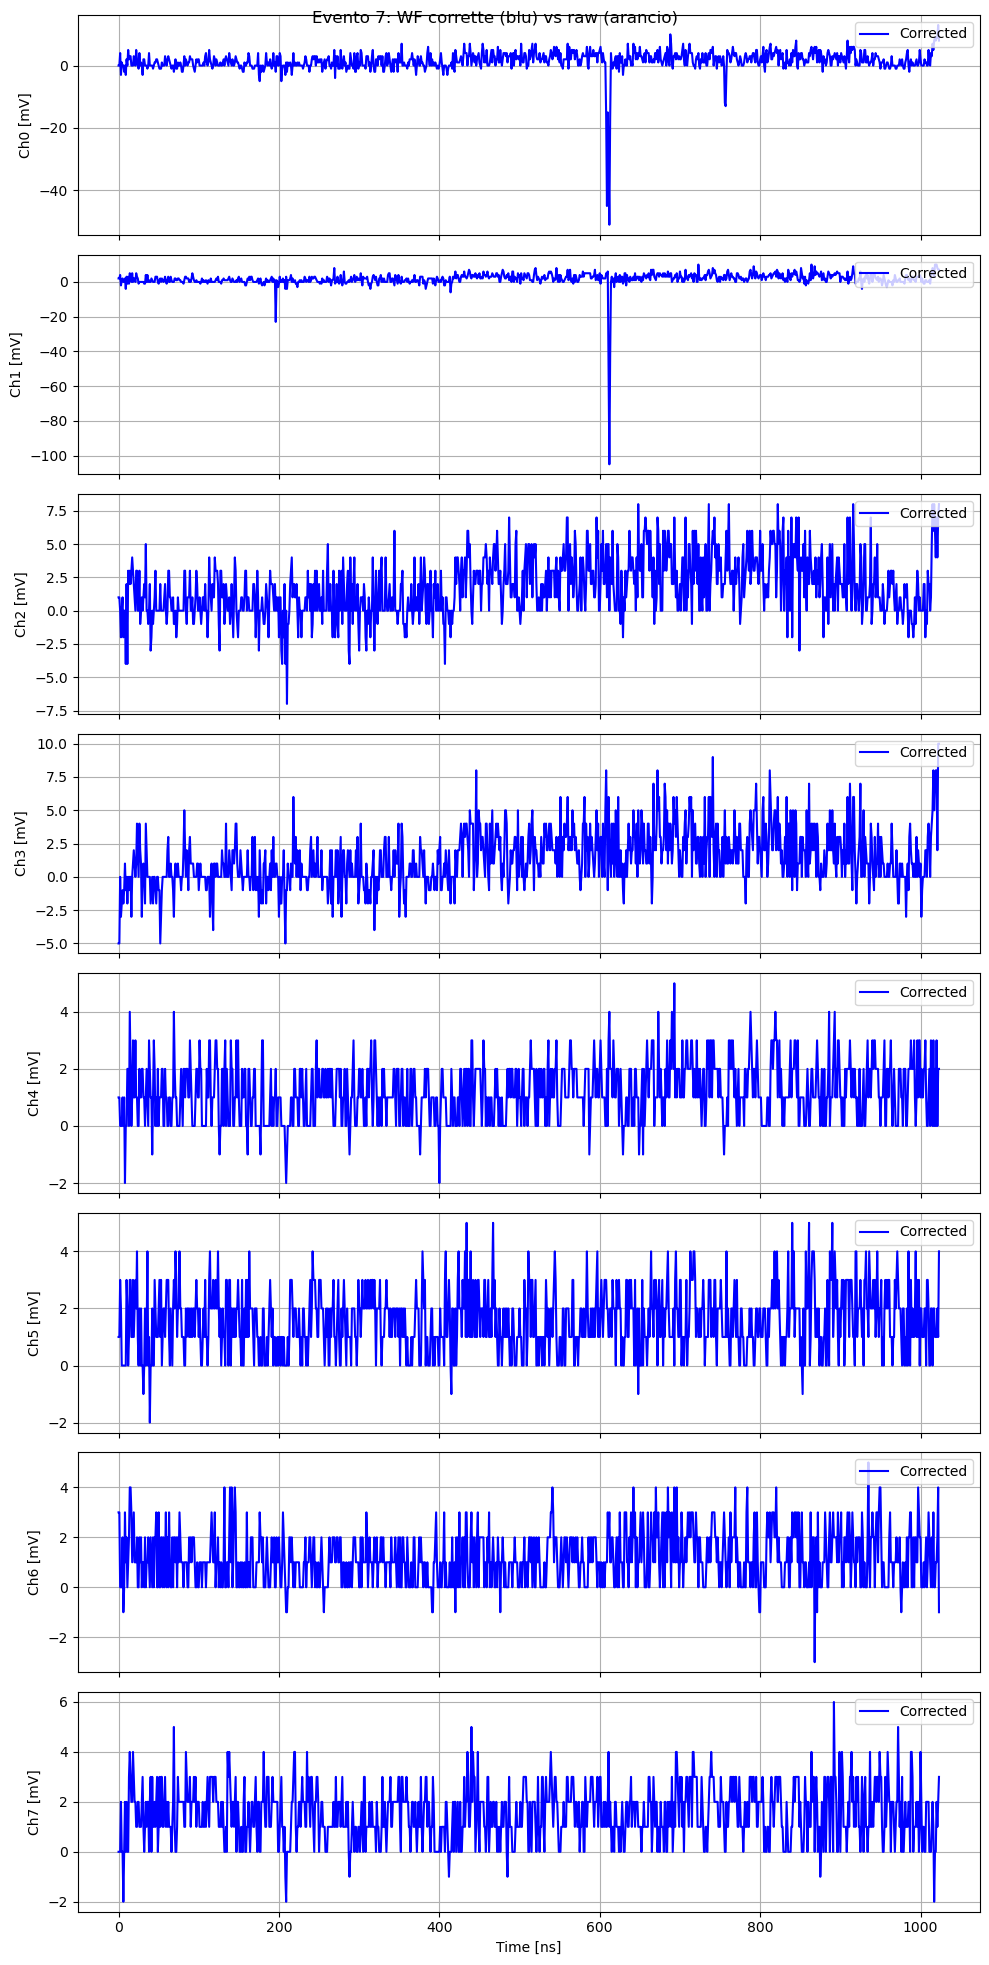

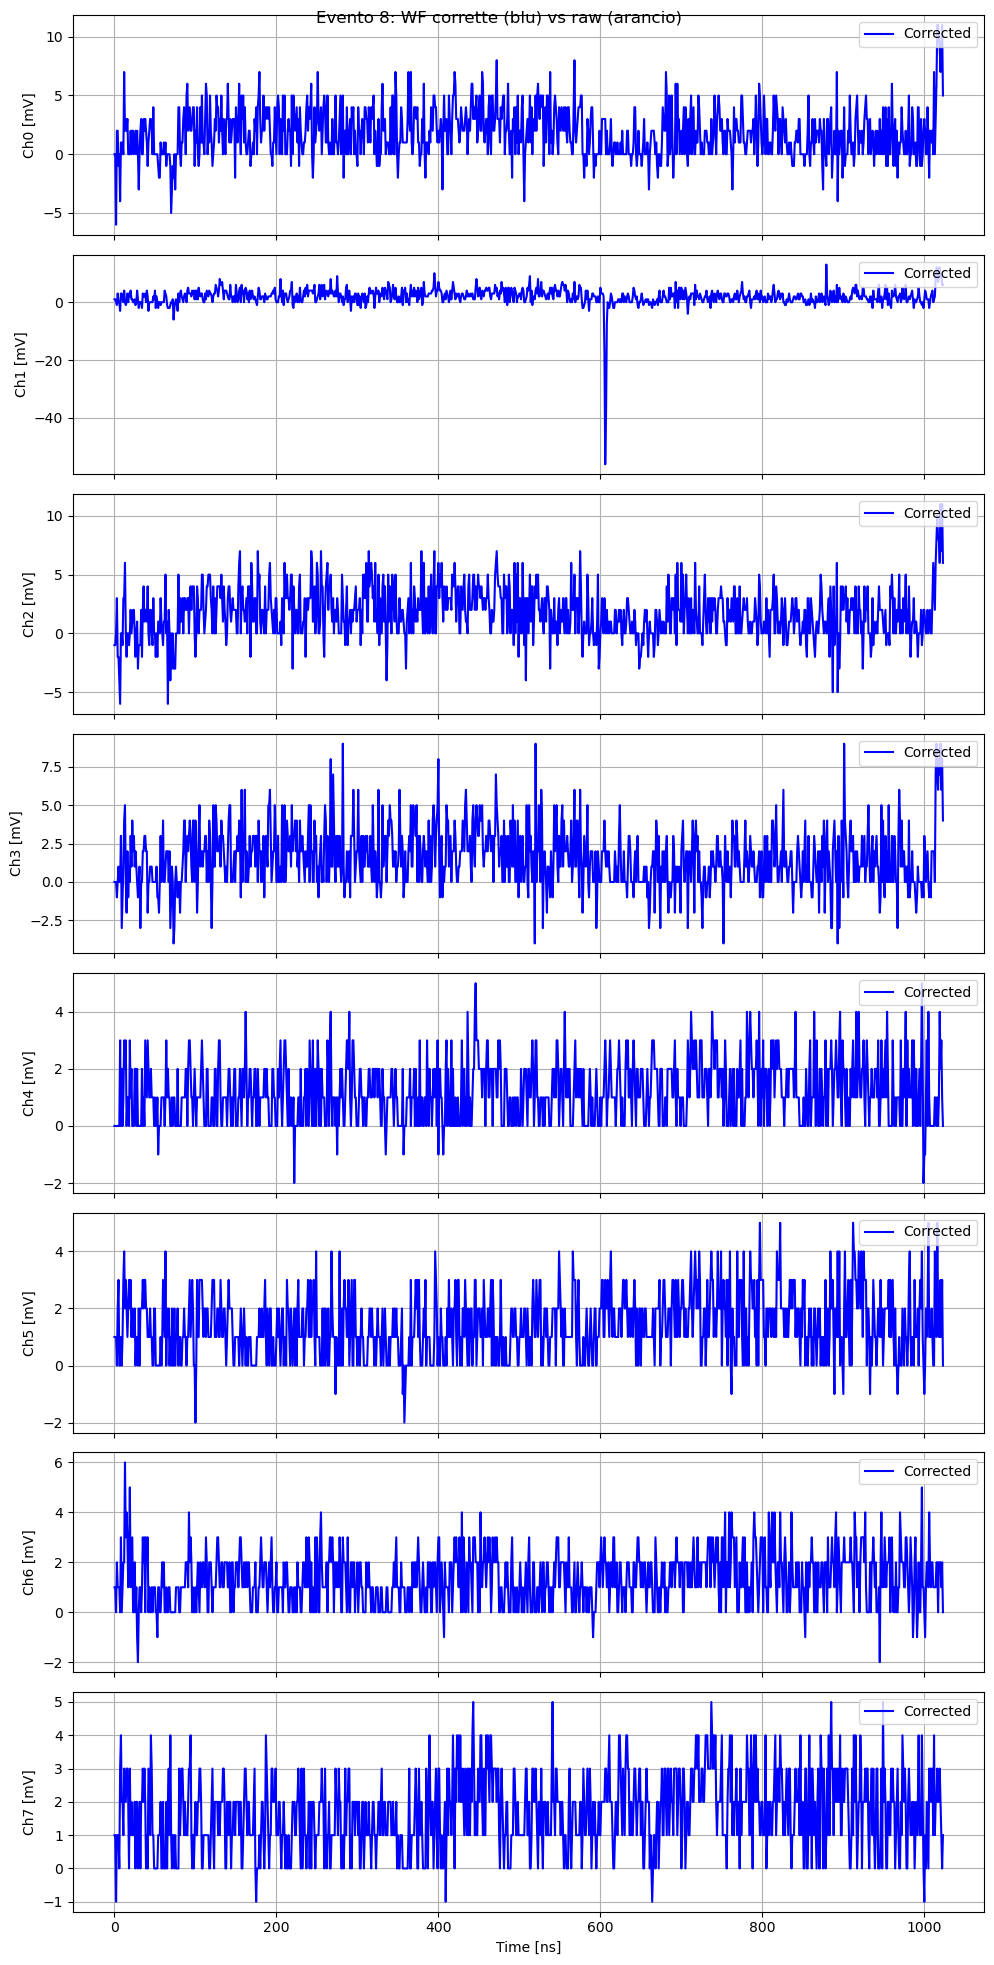

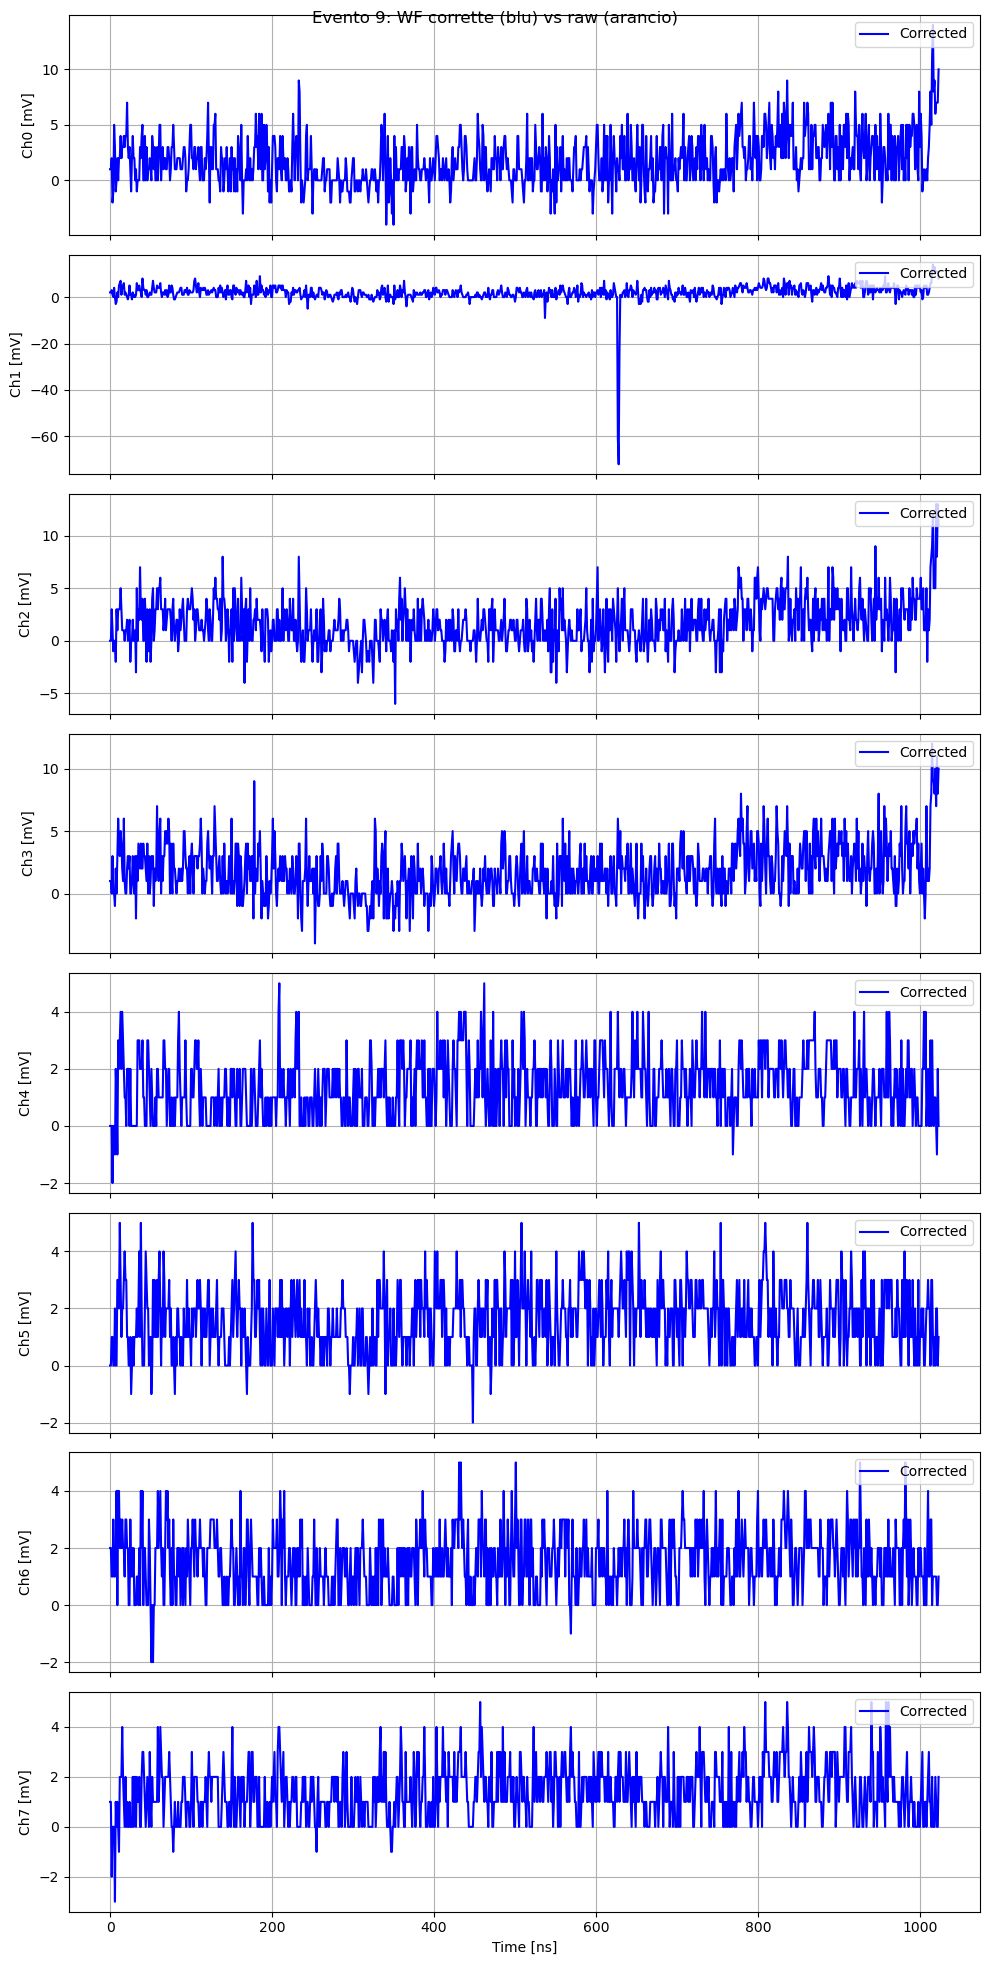


→ Temporary file /home/daq/daq-standalone/data/WC_proto_0000_1Gs_20PT.h5 deleted.


In [3]:
# === Import principali ===
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import shutil
import glob
import h5py

# === Directory dei dati ===
data_dir = "/home/daq/daq-standalone/data/"

# === Input: numero di run ===
run_number = input("Enter run number (e.g., 0002): ").strip()
if not run_number.isdigit():
    raise ValueError("Run number must be numeric (e.g., 0119).")

# === Ricerca automatica del file .h5.gz nella directory ===
pattern = os.path.join(data_dir, f"*{run_number}*.h5.gz")
files_found = sorted(glob.glob(pattern))

if not files_found:
    raise FileNotFoundError(f"No .h5.gz file found for run {run_number} in {data_dir}")

# Se c'è più di un file, chiedi quale aprire
if len(files_found) > 1:
    print(f"\nTrovati {len(files_found)} file corrispondenti al run {run_number}:")
    for i, fpath in enumerate(files_found):
        print(f"  [{i}] {os.path.basename(fpath)}")

    # Scelta utente
    while True:
        choice = input("\nSeleziona il file da aprire (indice): ").strip()
        if choice.isdigit() and int(choice) in range(len(files_found)):
            gz_path = files_found[int(choice)]
            break
        else:
            print("❌ Scelta non valida, riprova.")
else:
    gz_path = files_found[0]
    print(f"\n→ Trovato file: {os.path.basename(gz_path)}")

# === Prepara percorso file decompressato ===
base_filename = os.path.splitext(os.path.splitext(gz_path)[0])[0]  # rimuove .h5.gz
h5_path = base_filename + ".h5"

print("→ Decompressione in corso...\n")

# === Decompressione del file .h5.gz ===
with gzip.open(gz_path, 'rb') as f_in:
    with open(h5_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# === Apertura e analisi HDF5 ===
with h5py.File(h5_path, 'r') as f:
    print("📄 HEADER /config:")
    config = f["/config"]

    run_number = config.attrs["RunNumber"]
    record_length = config.attrs["RecordLength"]
    post_trigger = config.attrs["PostTriggerSize"]
    sampling_time = config.attrs["SamplingTime"]
    trigger_mode = config.attrs["TriggerMode"].decode() if isinstance(config.attrs["TriggerMode"], bytes) else config.attrs["TriggerMode"]
    channel_list = list(config.attrs["ChannelList"])

    print(f"  → RunNumber         = {run_number}")
    print(f"  → RecordLength      = {record_length}")
    print(f"  → PostTriggerSize   = {post_trigger}%")
    print(f"  → SamplingTime      = {sampling_time * 1e9:.1f} ns")
    print(f"  → TriggerMode       = {trigger_mode}")
    print(f"  → ChannelList       = {channel_list}\n")

    has_raw = "events_raw" in f
    if not has_raw:
        print("Il gruppo '/events_raw' non è presente. Mostrerò solo waveform corrette.\n")

    event_keys = sorted(f["/events"].keys(), key=lambda k: int(k.replace("event", "")))
    print(f"→ Numero eventi nel file: {len(event_keys)}\n")

    # === Loop sugli eventi ===
    for i, event_key in enumerate(event_keys):
        # Conversione esplicita in vettori NumPy
        data_corr = np.array(f["/events"][event_key][:], dtype=np.float64)
        data_raw = np.array(f["/events_raw"][event_key][:], dtype=np.float64) if has_raw else None

        total_samples = len(data_corr)
        n_channels = len(channel_list)
        samples_per_channel = total_samples // n_channels
        time_axis = np.arange(samples_per_channel) * sampling_time * 1e9  # ns

        if samples_per_channel * n_channels != total_samples:
            print(f"⚠️  Evento {i}: dimensione inattesa ({total_samples} samples)")
            continue

        # === Visualizzazione ===
        fig, axes = plt.subplots(n_channels, 1, figsize=(10, 2.5 * n_channels), sharex=True)
        fig.suptitle(f"Evento {i}: WF corrette (blu)" + (" vs raw (arancio)" if has_raw else ""))

        for idx, ch in enumerate(channel_list):
            wf_corr = np.array(data_corr[idx * samples_per_channel : (idx + 1) * samples_per_channel])
            axes[idx].plot(time_axis, wf_corr, label="Corrected", color="blue")

            if has_raw:
                wf_raw = np.array(data_raw[idx * samples_per_channel : (idx + 1) * samples_per_channel])
                # axes[idx].plot(time_axis, wf_raw, label="Raw", color="orange", alpha=0.6)

            axes[idx].set_ylabel(f"Ch{ch} [mV]")
            axes[idx].grid(True)
            axes[idx].legend(loc="upper right")

        axes[-1].set_xlabel("Time [ns]")
        plt.tight_layout()
        plt.show()

# === Pulizia: rimuovi il file decompressato ===
os.remove(h5_path)
print(f"\n→ Temporary file {h5_path} deleted.")
